In [1]:
import os
os.environ['KAGGLE_USERNAME'] = '' # 
os.environ['KAGGLE_KEY'] = '' # key

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip


  0%|          | 0.00/346M [00:00<?, ?B/s]
  1%|          | 2.00M/346M [00:00<00:31, 11.6MB/s]
  1%|          | 4.00M/346M [00:00<00:31, 11.4MB/s]
  2%|▏         | 6.00M/346M [00:00<00:31, 11.4MB/s]
  2%|▏         | 8.00M/346M [00:00<00:31, 11.3MB/s]
  3%|▎         | 10.0M/346M [00:00<00:31, 11.3MB/s]
  3%|▎         | 12.0M/346M [00:01<00:31, 11.3MB/s]
  4%|▍         | 14.0M/346M [00:01<00:30, 11.3MB/s]
  5%|▍         | 16.0M/346M [00:01<00:30, 11.3MB/s]
  5%|▌         | 18.0M/346M [00:01<00:30, 11.3MB/s]
  6%|▌         | 20.0M/346M [00:01<00:30, 11.3MB/s]
  6%|▋         | 22.0M/346M [00:02<00:30, 11.0MB/s]
  7%|▋         | 24.0M/346M [00:02<00:31, 10.7MB/s]
  8%|▊         | 26.0M/346M [00:02<00:32, 10.5MB/s]
  8%|▊         | 27.0M/346M [00:02<00:32, 10.2MB/s]
  8%|▊         | 29.0M/346M [00:02<00:32, 10.3MB/s]
  9%|▉         | 31.0M/346M [00:02<00:31, 10.5MB/s]
 10%|▉         | 33.0M/346M [00:03<00:31, 10.5MB/s]
 10%|▉         | 34.0M/346M [00:03<00:31, 10.5MB/s]
 10%|█         | 36.

# 패키지 로드

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 증강 기법

In [6]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
   'seg_train/seg_train',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
   'seg_test/seg_test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

In [13]:
from pprint import pprint
pprint(train_gen.class_indices)

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}


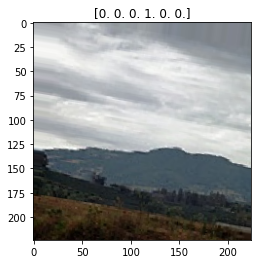

In [14]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

In [15]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(131, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[32,131] labels_size=[32,6]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at \Local\Temp/ipykernel_12964/102157532.py:3) ]] [Op:__inference_train_function_24396]

Function call stack:
train_function


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!') 

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(1)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)